# Inclined magnetic source

### Import the required packages

In [1]:
import numpy as np

In [2]:
import vedo

In [3]:
# set the backend for vedo
vedo.settings.default_backend= 'vtk'
#vedo.settings.default_backend= '2d'

In [4]:
from gravmag import utils, data_structures, aux_vedo
from gravmag.models import rectangular_prism as rp

In [5]:
import matplotlib.pyplot as plt

In [6]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [7]:
import pickle

### Define the study area and create the inclined magnetic source

In [8]:
# define the study area
# xmin, xmax, ymin, ymax, zmin, zmax
area = [0, 18000, 0, 21000, -500, 2000]

In [9]:
# define the center coordinates
area_center = (
    0.5*(area[0]+area[1]),
    0.5*(area[2]+area[3]),
    1000
)

In [10]:
# custom axes defining the study area
area_axes = aux_vedo.custom_axes(area=area)

In [11]:
model = pickle.load(open('inclined_source.pickle', 'rb'))
props = pickle.load(open('props_inclined_source.pickle', 'rb'))

In [12]:
# create a model of prisms for vedo
model_vedo = aux_vedo.gravmag2vedo_prisms(
    gravmag_prisms=model,
    scalar_props=props,
    cmap='jet',
    vmin=2,
    vmax=3,
)


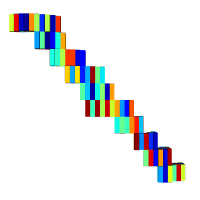

In [13]:
# add a colorbar to the prisms
model_vedo.add_scalarbar(
    title='props (SI)', 
    pos=(0.8,0.05),
    title_yoffset=15,
    font_size=14,
    #nlabels=5,
    #horizontal=True,
    label_format=':6.2f'
)

In [34]:
pl = vedo.Plotter()

pl += area_axes

pl += model_vedo.alpha(0.9)

# set a model view
pl.show(
    axes=0, zoom=1, interactive=True
)

# save the chosen view
pl.show(axes=0, zoom=0.95, interactive=False)
pl.screenshot('inclined_source_view_2.png')
pl.interactive()

pl.close()

### Compute the approximated total-field anomalies for different induced magnetization directions

In [15]:
inc = 20.2
dec_list = np.linspace(-45, 135, 11)

In [49]:
coordinates_grid = data_structures.grid_xy(
    area = area[:4],
    shape = (100, 105),
    z0 = -400
)

In [50]:
dx, dy = data_structures.grid_xy_spacing(
    area=coordinates_grid['area'],
    shape=coordinates_grid['shape']
)

In [51]:
dx, dy

(181.8181818181818, 201.92307692307693)

In [52]:
coordinates_full = data_structures.grid_xy_to_full_flatten(
    grid=coordinates_grid,
    ordering='xy'
)

In [53]:
tfa_list = []
for dec in dec_list:
    hat_u = utils.unit_vector(inc=inc, dec=dec)
    b = []
    for component in ['x', 'y', 'z']:
        b.append(
            rp.mag(
                coordinates=coordinates_full, 
                prisms=model, 
                mx=hat_u[0]*props, 
                my=hat_u[1]*props, 
                mz=hat_u[2]*props,
                field=component
            )
        )
    tfa_list.append(hat_u[0]*b[0] + hat_u[1]*b[1] + hat_u[2]*b[2])

In [54]:
rtp = rp.mag(
    coordinates=coordinates_full, 
    prisms=model, 
    mx=np.zeros_like(props), 
    my=np.zeros_like(props), 
    mz=props,
    field='z'
)

### Plot the data

In [55]:
# coordinates rearranged for plotting
# they are "views' of the original coordinates in 'coordinates_grid'
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x = coordinates_grid['x'],
    y = coordinates_grid['y'],
    shape = coordinates_grid['shape']
)

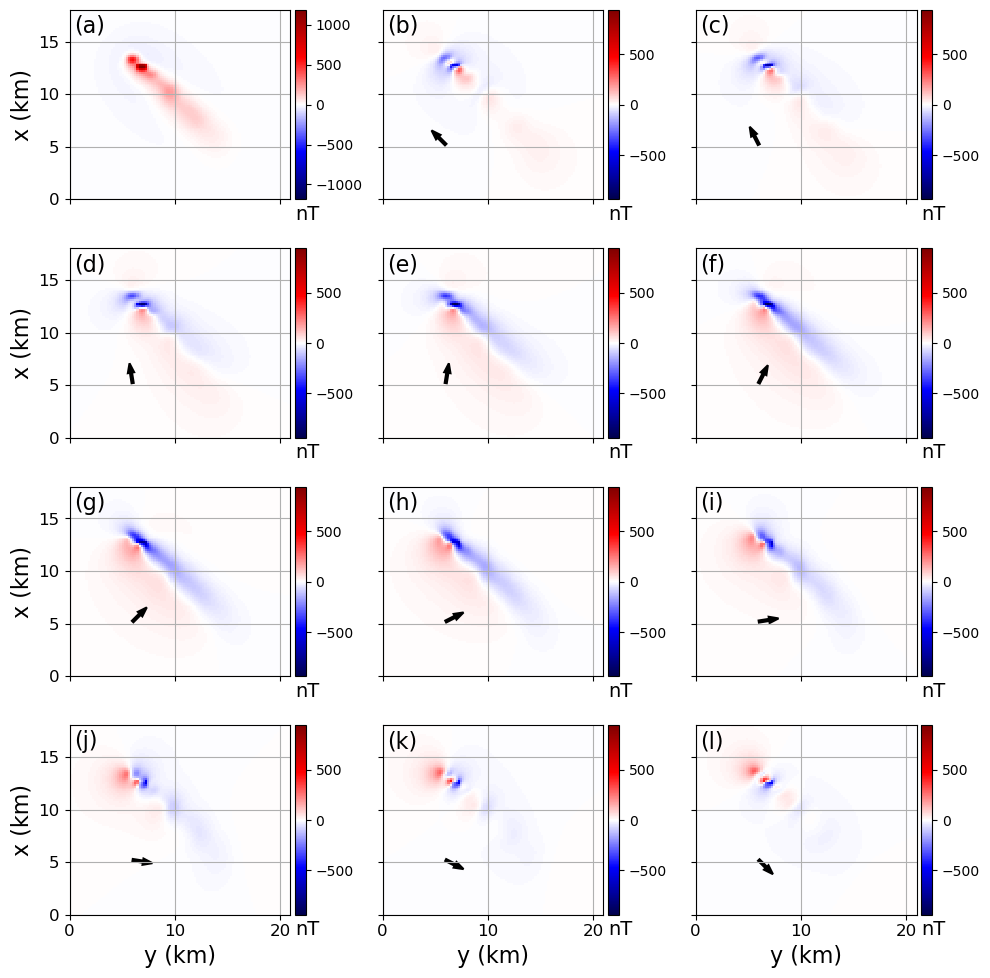

In [56]:
# plot figure
fig = plt.figure(
    layout= 'tight', 
    figsize=(10,10)
)
mosaic = fig.subplot_mosaic(
    mosaic = '''
             abc
             def
             ghi
             jkl
             ''',
    sharex=True, sharey=True
)

# plot the RTP
bound_rtp = np.max(np.abs(rtp))
ax = mosaic['a']
ax.axis('scaled')
im = ax.pcolormesh(
    Y*0.001, X*0.001, 
    data_structures.grid_xy_full_flatten_to_matrix(
        data=rtp,
        ordering='xy',
        shape=coordinates_grid['shape']
    ),
    cmap='seismic', vmin=-bound_rtp, vmax=bound_rtp
)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
cb = fig.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=10)
cb.ax.set_xlabel('nT', fontsize=14, loc='left')
ax.set_ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
ax.set_xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid()
ax.annotate('(a)', xy=(0.02, 0.88), xycoords='axes fraction', fontsize=16)

mosaic_elements = [
    'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'
]

labels = [
    '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)'
]

bound_tfa = np.max(np.abs(tfa_list))

for (mosaic_element, tfa, dec, label) in zip(
    mosaic_elements, tfa_list, dec_list, labels
):
    hat_u = utils.unit_vector(inc=inc, dec=dec)
    hat_u_horizontal = hat_u[:2]/np.linalg.norm(hat_u[:2])
    
    

    ax = mosaic[mosaic_element]
    ax.axis('scaled')
    im = ax.pcolormesh(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=tfa,
            ordering='xy',
            shape=coordinates_grid['shape']
        ),
        cmap='seismic', vmin=-bound_tfa, vmax=bound_tfa
    )
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=10)
    cb.ax.set_xlabel('nT', fontsize=14, loc='left')
    ax.set_ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    ax.set_xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid()
    ax.annotate(label, xy=(0.02, 0.88), xycoords='axes fraction', fontsize=16)
    ax.arrow(
        x=6, y=5.2, dx=hat_u_horizontal[1], dy=hat_u_horizontal[0], 
        width=0.2, length_includes_head=False, head_width=0.6, linewidth=1.5, color='black'
    )

# set vertical and horizontal spaces between subplots
#fig.subplots_adjust(wspace=0.20, hspace=0.30)
    
for element in ['a','d','g','j']:
    mosaic[element].set_ylabel('x (km)', fontsize=16)
for element in ['j','k', 'l']:
    mosaic[element].set_xlabel('y (km)', fontsize=16)

plt.savefig('tfa_inclined_source.png', dpi=300)

plt.show()